<a href="https://colab.research.google.com/github/adityasahu88/DL_PROJECTS/blob/main/AI_vs_Human_Generated_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle

In [2]:
!kaggle datasets download alessandrasala79/ai-vs-human-generated-dataset

Dataset URL: https://www.kaggle.com/datasets/alessandrasala79/ai-vs-human-generated-dataset
License(s): apache-2.0
100% 9.75G/9.76G [04:05<00:00, 43.7MB/s]
100% 9.76G/9.76G [04:05<00:00, 42.7MB/s]


In [3]:
!unzip -q ai-vs-human-generated-dataset.zip

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import tensorflow as tf
from tqdm.auto import tqdm
import cv2


In [5]:
train_df = pd.read_csv('train.csv')

In [6]:
train_df["label"] = train_df["label"].astype(str)
train_df["file_name"] = train_df["file_name"].str.replace("train_data/","")
train_df

,Unnamed: 0,file_name,label
0,0,a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,041be3153810433ab146bc97d5af505c.jpg,0
2,2,615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1
...,...,...,...
79945,79945,9283b107f6274279b6f15bbe77c523aa.jpg,0
79946,79946,4c6b17fe6dd743428a45773135a10508.jpg,1
79947,79947,1ccbf96d04e342fd9f629ad55466b29e.jpg,0
79948,79948,ff960b55f296445abb3c5f304b52e104.jpg,1


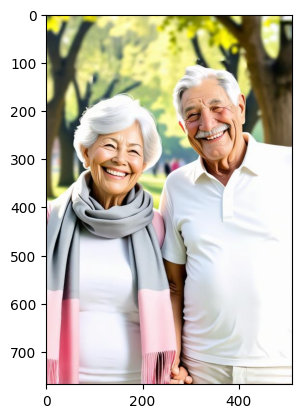

In [7]:
# lets check one image of human and AI generated
img =cv2.imread('train_data/a6dcb93f596a43249135678dfcfc17ea.jpg')
#img = cv2.resize(img,(224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

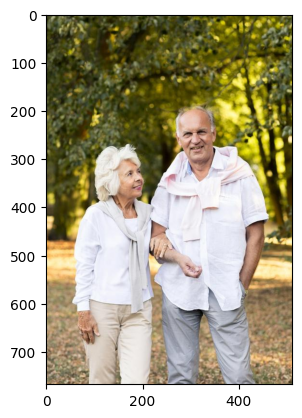

In [8]:
# lets check one image of human and AI generated
img =cv2.imread('train_data/041be3153810433ab146bc97d5af505c.jpg')
#img = cv2.resize(img,(224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [9]:
train_df.shape

(79950, 3)

In [10]:
train_df['label'].value_counts()

,count
label,
1,39975
0,39975


Mapping of IDs to Labels: {0: 'human', 1: 'AI-generated'}

In [11]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1,
                                                      rescale=1/255.0)

In [30]:
batch_size = 32

In [50]:
# we will use smal set of records so that computation  will be easier

# Number of unique labels
num_labels = train_df['label'].nunique()
num_labels

# Records per label (equal distribution)
samples_per_label = 2000 // num_labels
sample_df=train_df.groupby('label').apply(lambda x: x.sample(n=samples_per_label, random_state=42))
sample_df = sample_df.reset_index(drop=True)
sample_df.shape

<ipython-input-50-27d527586090>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df=train_df.groupby('label').apply(lambda x: x.sample(n=samples_per_label, random_state=42))


(2000, 3)

In [51]:
train_idg = idg.flow_from_dataframe(sample_df,
                                    directory="train_data/",
                                    x_col='file_name',
                                    y_col='label',
                                    batch_size=batch_size,
                                    subset='training',
                                    target_size =(150,150))

Found 1800 validated image filenames belonging to 2 classes.


In [52]:
val_idg = idg.flow_from_dataframe(sample_df,
                                    directory="train_data/",
                                    x_col='file_name',
                                    y_col='label',
                                    batch_size=batch_size,
                                    subset='validation',
                                    target_size =(150,150))

Found 200 validated image filenames belonging to 2 classes.


In [53]:
# Create the Model
model =tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(150,150,3),name="Input"))
model.add(tf.keras.layers.Flatten(name="Flatten_layer"))
model.add(tf.keras.layers.Dense(512,activation=tf.keras.activations.relu,name='HL1'))
model.add(tf.keras.layers.Dense(128,activation=tf.keras.activations.relu,name='HL2'))
model.add(tf.keras.layers.Dense(32,activation=tf.keras.activations.relu,name='HL3'))
model.add(tf.keras.layers.Dense(8,activation=tf.keras.activations.relu,name='HL4'))

# Add the Output layer

model.add(tf.keras.layers.Dense(2,activation=tf.keras.activations.softmax,name='Output_Layer'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten_layer (Flatten)              │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL1 (Dense)                          │ (None, 512)                 │      34,560,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL2 (Dense)                          │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL3 (Dense)                          │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL4 (Dense)                          │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,630,586 (132.11 MB)

 Trainable params: 34,630,586 (132.11 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics =['accuracy'])

In [55]:
model.fit(train_idg,epochs=10,validation_data=val_idg,batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 390ms/step - accuracy: 0.5309 - loss: 0.8557 - val_accuracy: 0.0900 - val_loss: 0.7604
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 386ms/step - accuracy: 0.5673 - loss: 0.6802 - val_accuracy: 0.8100 - val_loss: 0.6294
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 408ms/step - accuracy: 0.6032 - loss: 0.6657 - val_accuracy: 0.0000e+00 - val_loss: 1.3244
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 389ms/step - accuracy: 0.6055 - loss: 0.6602 - val_accuracy: 0.6700 - val_loss: 0.6852
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 380ms/step - accuracy: 0.5922 - loss: 0.6745 - val_accuracy: 0.2400 - val_loss: 0.7767
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 417ms/step - accuracy: 0.6303 - loss: 0.6400 - val_accuracy: 0.6300 - val_loss: 0.6900
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 378ms/step - accuracy: 0.6062 - loss: 0.6502 - val_accuracy: 0.0750 - val_loss: 0.9583
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 377ms/step - accuracy: 0.6264 - loss: 0.6406 - val_

In [56]:
df_performance =pd.DataFrame()
df_performance =pd.DataFrame(model.history.history)
df_performance

,accuracy,loss,val_accuracy,val_loss
0,0.531667,0.753183,0.090,0.760358
1,0.573333,0.676963,0.810,0.629366
2,0.582778,0.673021,0.000,1.324402
3,0.607222,0.657775,0.670,0.685164
4,0.585556,0.679168,0.240,0.776655
5,0.617222,0.648297,0.630,0.690025
6,0.603889,0.651252,0.075,0.958266
7,0.636667,0.631640,0.020,1.271690
8,0.636111,0.638367,0.085,0.999296
9,0.645556,0.625754,0.850,0.505968


In [57]:
# lets use CNN Model for more accuracy and feature selection

In [58]:
del model


In [59]:
# Create the Model
model =tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(150,150,3),name="Input Shape"))

# apply CNN

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),
                                 padding="valid",
                                 strides=(1,1),
                                 activation=tf.keras.activations.relu,
                                 name ="Conv1"))

# (150,150,3) (3,3)-->(150-3+1)/1-->(148,148,16)

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                    strides=(2,2),
                                    padding="valid",
                                    name="Pool1"))
# (148,148,16) --(2,2)---> (74,74,16)


model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),
                                 padding="valid",
                                 strides=(1,1),
                                 activation=tf.keras.activations.relu,
                                 name ="Conv2"))

# (74,74,16) (3,3)-->(74-3+1)/1-->(72,72,32)

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                    strides=(2,2),
                                    padding="valid",
                                    name="Pool2"))
# (72,72,32) --(2,2)---> (36,36,32)

model.add(tf.keras.layers.Flatten(name="Flatten_layer"))
model.add(tf.keras.layers.Dense(512,activation=tf.keras.activations.relu,name='HL1'))
model.add(tf.keras.layers.Dense(128,activation=tf.keras.activations.relu,name='HL2'))
model.add(tf.keras.layers.Dense(32,activation=tf.keras.activations.relu,name='HL3'))
model.add(tf.keras.layers.Dense(8,activation=tf.keras.activations.relu,name='HL4'))

# Add the Output layer

model.add(tf.keras.layers.Dense(2,activation=tf.keras.activations.softmax,name='Output_Layer'))

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                       │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_layer (Flatten)              │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL1 (Dense)                          │ (None, 512)                 │      21,234,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL2 (Dense)                          │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL3 (Dense)                          │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HL4 (Dense)                          │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,309,338 (81.29 MB)

 Trainable params: 21,309,338 (81.29 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics =['accuracy'])

In [61]:
model.fit(train_idg,epochs=10,validation_data=val_idg,batch_size=batch_size)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 55s 955ms/step - accuracy: 0.5131 - loss: 0.6960 - val_accuracy: 0.0000e+00 - val_loss: 0.8616
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 939ms/step - accuracy: 0.5716 - loss: 0.6718 - val_accuracy: 0.0000e+00 - val_loss: 0.7749
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 938ms/step - accuracy: 0.5600 - loss: 0.6704 - val_accuracy: 0.0000e+00 - val_loss: 0.7872
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 926ms/step - accuracy: 0.5692 - loss: 0.6620 - val_accuracy: 0.0000e+00 - val_loss: 0.9151
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 54s 941ms/step - accuracy: 0.6215 - loss: 0.6414 - val_accuracy: 0.2150 - val_loss: 0.8192
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 935ms/step - accuracy: 0.6477 - loss: 0.6291 - val_accuracy: 0.7150 - val_loss: 0.6880
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 52s 915ms/step - accuracy: 0.6783 - loss: 0.6020 - val_accuracy: 0.6250 - val_loss: 0.7391
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 54s 946ms/step - accuracy: 0.7165 - loss: 0